## AIPI 590.01 Explainable AI

### Assignment 3: Machine Learning Court

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nrutachoudhari/AIPI590.01_Explainable_AI_Assignments/blob/main/HW3_Machine_Learning_Court/AIPI%20590.01%20Assignment%203.ipynb)

#### 💰 Case 1: Loan Approval  🟥 Prosecution

🔍 Scenario
Jane Dow, a 37-year-old professional woman with a Bachelor's degree and full-time executive role, applied for a premium credit product. The bank’s model—trained to predict income level as a proxy for eligibility—classified her as earning ≤$50K, resulting in denial. She disputes the fairness of the decision.

🟥 Prosecution
Evaluate whether the model’s decision may have been influenced by inappropriate or unfair reasoning. Explore whether the explanation aligns with what should be expected in a fair credit decision.

In [1]:
# importing the necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

/Users/nrutachoudhari/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# loading the data
from sklearn.datasets import fetch_openml
adult = fetch_openml(name = 'adult', version = 2, as_frame = True)
df = adult.frame

In [3]:
# cleaning and preprocessing
df = df.dropna()
df = df.copy()
encoders = {}
label_cols = df.select_dtypes(include='category').columns.tolist()

for col in label_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop(["class", "fnlwgt"], axis=1)
y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# training the simple RF model
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9045

    accuracy                           1.00      9045
   macro avg       1.00      1.00      1.00      9045
weighted avg       1.00      1.00      1.00      9045



In [4]:
# 🎯 Focus Instance: Loan Rejection Case (Jane Dow)

jane_encoded = {
    'age': 37,
    'workclass': encoders['workclass'].transform(['Private'])[0],
    'education': encoders['education'].transform(['Bachelors'])[0],
    'marital-status': encoders['marital-status'].transform(['Never-married'])[0],
    'occupation': encoders['occupation'].transform(['Exec-managerial'])[0],
    'relationship': encoders['relationship'].transform(['Not-in-family'])[0],
    'race': encoders['race'].transform(['White'])[0],
    'sex': encoders['sex'].transform(['Female'])[0],
    'hours-per-week': 50,
    'native-country': encoders['native-country'].transform(['United-States'])[0],
    'capital-gain': 0,
    'capital-loss': 0,
    'education-num': 13,
}

jane_df = pd.DataFrame([jane_encoded])
jane_df = jane_df[X_train.columns]
pred = model_adult.predict(jane_df)
print("Prediction for Jane Dow (Loan Eligibility):", "Approved" if pred[0] == 1 else "Denied")


Prediction for Jane Dow (Loan Eligibility): Denied


> At first glance, the model looks flawless as it got every single prediction right. The model has achieved a 100% precision, recall, and accuracy on the test set. Such performance is extremely unusual in practice and raises concerns about data leakage or overfitting.
> 
> So while the model confidently denied Jane, that confidence does not mean that the decision was fair as the model could have memorized biases in the data. The model could just be repeating the same biases it encountered in the training data.
>
> Thus, it becomes important to look into which features drove the decision. I will be using SHAP and LIME for this.

### **SHAP Analysis**

In [5]:
# initializing the SHAP explainer for tree-based models
explainer = shap.TreeExplainer(model_adult)

# calculating the SHAP values for Jane's instance
jane_shap_values = explainer.shap_values(jane_df)

# checking the shape and structure of the SHAP values
print(f"SHAP values shape: {np.array(jane_shap_values).shape}")
print(f"SHAP values type: {type(jane_shap_values)}")

SHAP values shape: (1, 13)
SHAP values type: <class 'numpy.ndarray'>


In [6]:
# handling different SHAP output formats
if isinstance(jane_shap_values, list) and len(jane_shap_values) == 2:
    # this means it is in a multi-class format
    shap_values_class1 = jane_shap_values[1]

elif isinstance(jane_shap_values, np.ndarray) and jane_shap_values.ndim == 2:
    # this means it is a single array format
    shap_values_class1 = jane_shap_values

else:
    # using it directly if it is a single array
    shap_values_class1 = jane_shap_values

In [7]:
print("SHAP Values for Jane Dow:")
feature_importance = pd.DataFrame({
    'Feature': jane_df.columns,
    'SHAP Value': shap_values_class1[0],
    'Feature Value': jane_df.iloc[0].values
})
feature_importance = feature_importance.sort_values('SHAP Value', key = abs, ascending=False)
print(feature_importance)

SHAP Values for Jane Dow:
           Feature  SHAP Value  Feature Value
0              age         0.0             37
1        workclass         0.0              2
2        education         0.0              9
3    education-num         0.0             13
4   marital-status         0.0              4
5       occupation         0.0              3
6     relationship         0.0              1
7             race         0.0              4
8              sex         0.0              0
9     capital-gain         0.0              0
10    capital-loss         0.0              0
11  hours-per-week         0.0             50
12  native-country         0.0             38


In [8]:
# getting the correct expected value based on the format
if isinstance(explainer.expected_value, (list, np.ndarray)) and len(explainer.expected_value) > 1:
    expected_val = explainer.expected_value[1]
else:
    expected_val = explainer.expected_value

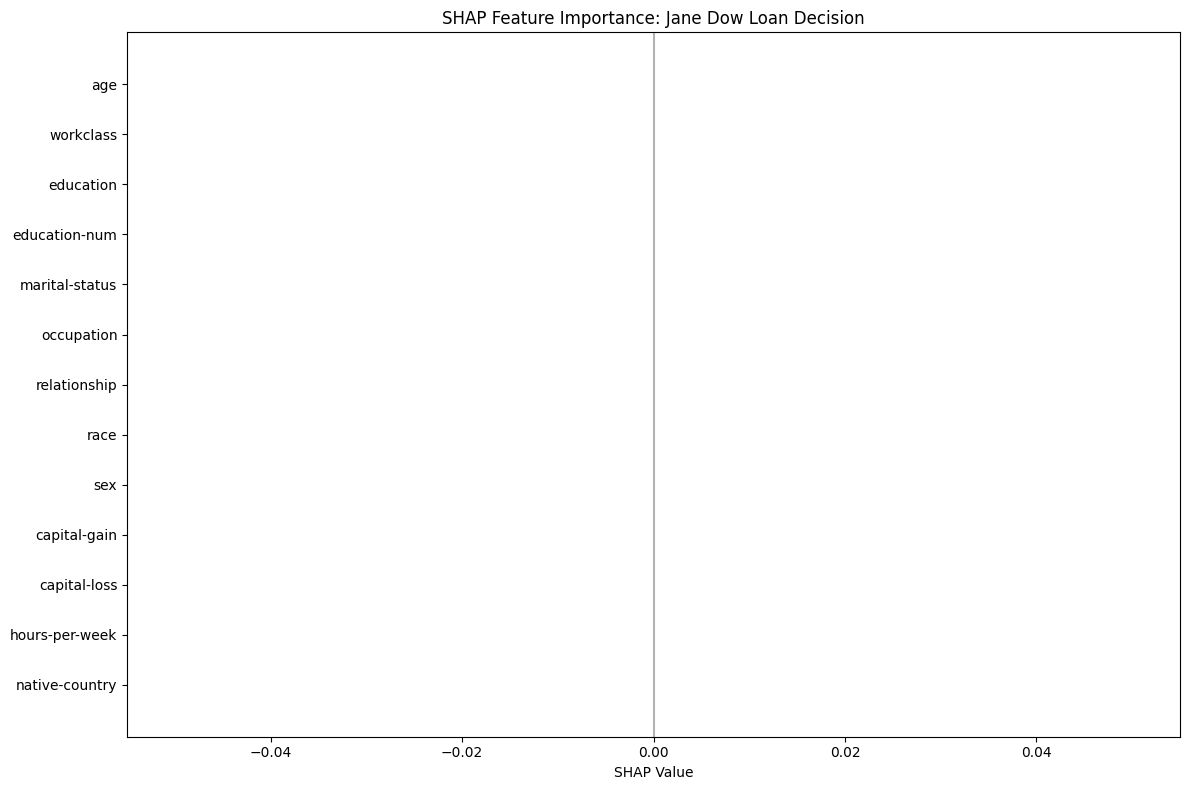

In [9]:
# creating a bar plot of SHAP values
plt.figure(figsize = (12, 8))

feature_names = jane_df.columns.tolist()
shap_vals = shap_values_class1[0]

# sorting by absolute importance
indices = np.argsort(np.abs(shap_vals))[::-1]

colors = ['red' if val < 0 else 'green' for val in shap_vals[indices]]
plt.barh(range(len(shap_vals)), shap_vals[indices], color = colors, alpha = 0.7)
plt.yticks(range(len(shap_vals)), [feature_names[i] for i in indices])
plt.xlabel('SHAP Value')
plt.title('SHAP Feature Importance: Jane Dow Loan Decision')
plt.axvline(x=0, color = 'black', linestyle = '-', alpha = 0.3)
plt.tight_layout()
plt.show()

> When we applied SHAP to Jane's case, all feature combinations came out as zero. It means that nothing mattered when it came to Jane being denied the credit product, not her age or profession or education or race.
>
> In a real-world credit decision, we would expect some factors to contribute to the outcome to whether a customer is able to get a product. The complete absence of any contributions may indicate that the model is making its predictions blindly without actually learning any meaningful relationships from the data.
>
> This raises concerns that the model is not valid for fair loan approval decisions.

### **LIME Analysis**

In [10]:
# creating a wrapper function that ensures proper probability format
def predict_proba_wrapper(X):
    """Wrapper to ensure LIME gets proper probability format"""
    if hasattr(X, 'shape') and X.ndim == 1:
        X = X.reshape(1, -1)
    
    # converting to DataFrame with proper column names to avoid warning
    if isinstance(X, np.ndarray):
        X_df = pd.DataFrame(X, columns=X_train.columns)
    else:
        X_df = X
    
    proba = model_adult.predict_proba(X_df)
    
    # ensuring probabilities sum to 1 and have correct shape
    if proba.shape[1] == 1:
        # binary classification with single column output
        proba = np.column_stack([1 - proba.flatten(), proba.flatten()])
    
    # normalizing to ensure probabilities sum to 1
    proba = proba / proba.sum(axis=1, keepdims=True)
    
    return proba

In [11]:
# creating a LIME explainer with proper setup
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=list(X_train.columns),
    class_names=['≤50K (Denied)', '>50K (Approved)'],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# generating explanations for Jane's instance
lime_explanation = lime_explainer.explain_instance(
    jane_df.iloc[0].values, 
    predict_proba_wrapper,
    num_features=10
)

print("LIME Explanation for Jane Dow:")

# extracting LIME feature importance
lime_features = lime_explanation.as_list()
print("\nLIME Feature Importance:")
for feature, importance in lime_features:
    print(f"{feature}: {importance:.4f}")

LIME Explanation for Jane Dow:

LIME Feature Importance:
28.00 < age <= 37.00: 0.0000
workclass <= 2.00: 0.0000
education <= 9.00: 0.0000
10.00 < education-num <= 13.00: 0.0000
2.00 < marital-status <= 4.00: 0.0000
2.00 < occupation <= 6.00: 0.0000
0.00 < relationship <= 1.00: 0.0000
race <= 4.00: 0.0000
sex <= 0.00: 0.0000
capital-gain <= 0.00: 0.0000


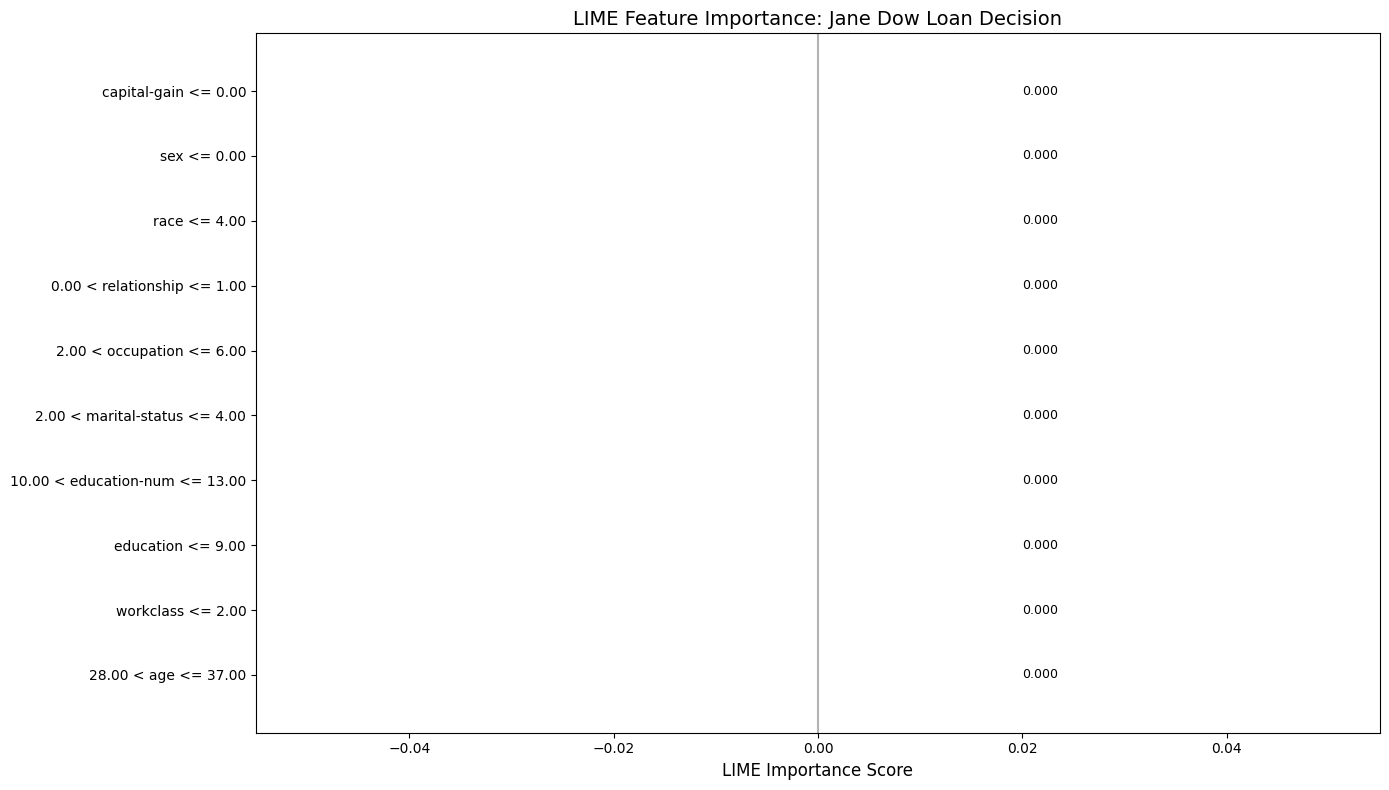


LIME Feature Analysis Table:
                       Feature  LIME Importance  Abs Importance
          28.00 < age <= 37.00              0.0             0.0
             workclass <= 2.00              0.0             0.0
             education <= 9.00              0.0             0.0
10.00 < education-num <= 13.00              0.0             0.0
 2.00 < marital-status <= 4.00              0.0             0.0
     2.00 < occupation <= 6.00              0.0             0.0
   0.00 < relationship <= 1.00              0.0             0.0
                  race <= 4.00              0.0             0.0
                   sex <= 0.00              0.0             0.0
          capital-gain <= 0.00              0.0             0.0


In [12]:
# creating LIME bar plot
plt.figure(figsize=(14, 8))
features, importances = zip(*lime_features)
y_pos = np.arange(len(features))

colors = ['red' if imp < 0 else 'green' for imp in importances]
bars = plt.barh(y_pos, importances, color=colors, alpha=0.7)
plt.yticks(y_pos, features, fontsize=10)
plt.xlabel('LIME Importance Score', fontsize=12)
plt.title('LIME Feature Importance: Jane Dow Loan Decision', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
# adding value labels on bars
for i, (bar, imp) in enumerate(zip(bars, importances)):
    plt.text(imp + (0.02 * np.sign(imp) if imp != 0 else 0.02), i, f'{imp:.3f}', 
            va='center', ha='left' if imp >= 0 else 'right', fontsize=9)
    
plt.tight_layout()
plt.show()

# creating a detailed LIME analysis table
lime_df = pd.DataFrame(lime_features, columns=['Feature', 'LIME Importance'])
lime_df['Abs Importance'] = abs(lime_df['LIME Importance'])
lime_df = lime_df.sort_values('Abs Importance', ascending=False)
    
print("\nLIME Feature Analysis Table:")
print(lime_df.to_string(index=False))

> The LIME analysis also showed that none of the features contributed to Jane's loan denial. Every single factor received an importance score of zero. This reinforces the concerns raised by SHAP that the model is not basing its decisions on meaningful applicant characteristics. It is producing outcomes without considering the applicant's profile which is a strong indicator of data leakage or model invalidity.

> It would be valuable to understand why the model behaves the way it does. To understand this, going to delve further into the data characteristics.

### **Further EDA**

In [13]:
# finding the number of rows in the data
print(f"Number of rows in the dataset: {df.shape[0]}")

Number of rows in the dataset: 45222


In [14]:
# y is defined as the target variable in the preprocessing step
# checking the distribution of the target variable
print(y.value_counts())

class
0    45222
Name: count, dtype: int64


> We can see that only class 0 is represented in the data, meaning that the training data only had case rejections and no approvals. As a result, the model never encountered any examples of approvals and just rejected everyone automatically. Both SHAP and LIME showed that none of Jane's personal information mattered.

In [15]:
# checking if the original dataset always had only one class
# loading the data again to verify
adult_full = fetch_openml(name='adult', version=2, as_frame=True)
df_full = adult_full.frame.dropna()
print(df_full['class'].value_counts())

class
<=50K    34014
>50K     11208
Name: count, dtype: int64


> We can see that both cases are represented here. In the pre-processing done for the model, the `class` variable is encoded to be 0 or 1. But when this conversion is done, all the cases are converted to 0.

In [16]:
print(df_full.dtypes)

age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
class             category
dtype: object


> The `class` variable is a categorical one, so it is possible that the conversion didn't work as planned and all cases became a 0.

In [17]:
# converting the class variable to a string before encoding
df_full["class"] = df_full["class"].astype(str)
y = (df_full["class"] == ">50K").astype(int)

In [18]:
print(y.value_counts())

class
0    34014
1    11208
Name: count, dtype: int64


> Okay, the encoding for y has been done correctly, with both approvals and rejections being represented in the data. Let's proceed with the rest of the pre-processing and fit the model.

In [19]:
# continuing with the preprocessing
encoders = {}
label_cols = df_full.select_dtypes(include="category").columns.tolist()
label_cols = [c for c in label_cols if c != "class"]

for col in label_cols:
    le = LabelEncoder()
    df_full[col] = df_full[col].astype(str)
    df_full[col] = le.fit_transform(df_full[col])
    encoders[col] = le

X = df_full.drop(["class", "fnlwgt"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# training the simple RF model
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6842
           1       0.72      0.61      0.66      2203

    accuracy                           0.85      9045
   macro avg       0.80      0.77      0.78      9045
weighted avg       0.84      0.85      0.84      9045



> With this model, we can see that the accuracy has dropped to 85%. The recall for class 1 is 0.61 which indicates that there are still 39% of high-income applicants who are misclassified as low-income.

In [20]:
# 🎯 Focus Instance: Loan Rejection Case (Jane Dow)

jane_encoded = {
    'age': 37,
    'workclass': encoders['workclass'].transform(['Private'])[0],
    'education': encoders['education'].transform(['Bachelors'])[0],
    'marital-status': encoders['marital-status'].transform(['Never-married'])[0],
    'occupation': encoders['occupation'].transform(['Exec-managerial'])[0],
    'relationship': encoders['relationship'].transform(['Not-in-family'])[0],
    'race': encoders['race'].transform(['White'])[0],
    'sex': encoders['sex'].transform(['Female'])[0],
    'hours-per-week': 50,
    'native-country': encoders['native-country'].transform(['United-States'])[0],
    'capital-gain': 0,
    'capital-loss': 0,
    'education-num': 13,
}

jane_df = pd.DataFrame([jane_encoded])
jane_df = jane_df[X_train.columns]
pred = model_adult.predict(jane_df)
print("Prediction for Jane Dow (Loan Eligibility):", "Approved" if pred[0] == 1 else "Denied")


Prediction for Jane Dow (Loan Eligibility): Denied


> Jane's application in this case is also denied, which could be influenced by the model's bias towards underpredicting higher-income cases. Let's dig further by analyzing which attributes could be contributing to this.

### **SHAP Analysis - Modified Data**

In [21]:
# initializing the SHAP explainer for tree-based models
explainer = shap.TreeExplainer(model_adult)

# calculating the SHAP values for Jane's instance
jane_shap_values = explainer.shap_values(jane_df)

# checking the shape and structure of the SHAP values
print(f"SHAP values shape: {np.array(jane_shap_values).shape}")
print(f"SHAP values type: {type(jane_shap_values)}")

SHAP values shape: (1, 13, 2)
SHAP values type: <class 'numpy.ndarray'>


In [22]:
# checking the type and length of jane_shap_values before proceeding
type(jane_shap_values), len(jane_shap_values) if isinstance(jane_shap_values, list) else "not a list"
jane_shap_values[0].shape if isinstance(jane_shap_values, list) else jane_shap_values.shape

(1, 13, 2)

In [23]:
print("SHAP Values for Jane Dow:")
# converting Jane’s encoded instance as a dataframe
jane_df = pd.DataFrame([jane_encoded])

# computing SHAP values
shap_values = explainer.shap_values(jane_df)

# extracting Jane's predicted class
pred_class = pred[0]

# extracting SHAP values for Jane and her predicted class
shap_values_jane = shap_values[0, :, pred_class]

# creating a SHAP analysis table
shap_table = pd.DataFrame({
    "Feature": jane_df.columns,
    "Feature Value": jane_df.iloc[0].values,
    "SHAP Value": shap_values_jane
})

# sorting by absolute SHAP value
shap_table["Abs SHAP"] = abs(shap_table["SHAP Value"])
shap_table = shap_table.sort_values("Abs SHAP", ascending=False).reset_index(drop=True)

print(shap_table)


SHAP Values for Jane Dow:
           Feature  Feature Value  SHAP Value  Abs SHAP
0             race              4    0.075697  0.075697
1   marital-status              4    0.048088  0.048088
2     capital-loss              0    0.038881  0.038881
3       occupation              3    0.037960  0.037960
4   native-country             38    0.024075  0.024075
5     relationship              1    0.013563  0.013563
6              age             37   -0.012616  0.012616
7   hours-per-week             50   -0.010540  0.010540
8     capital-gain              0    0.006063  0.006063
9    education-num             13   -0.006031  0.006031
10             sex              0    0.005831  0.005831
11       education              9   -0.005295  0.005295
12       workclass              2    0.002987  0.002987


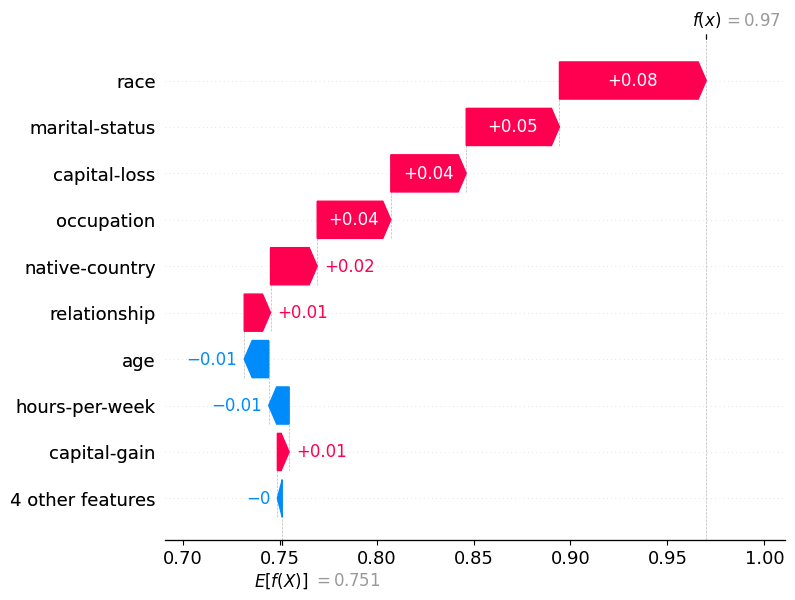

In [24]:
# creating a waterfall plot for Jane's SHAP values
shap.initjs()

shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[pred_class],
    shap_values_jane,
    feature_names=jane_df.columns
)

> The top contributors for Jane's denial based on largest value of Absolute SHAP value are:
> * race (0.0757): race contributed positively towards denial
> * marital-status (0.0481): marital status increased denial likelihood
> * capital-loss (0.0389): capital loss increased denial likelihood
> * occupation (0.0380):
>
> The model relied heavily on demographic features rather than purely income-related or professional features, which could indicate biasedness or unfairness in the decision-making process.

### **LIME Analysis - Modified Data**

In [25]:
print("LIME Analysis for Jane Dow:")
# creating LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['≤50K (Denied)', '>50K (Approved)'],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# explaining Jane's instance
lime_exp = lime_explainer.explain_instance(
    jane_df.iloc[0].values,
    model_adult.predict_proba, 
    num_features=10
)

# getting the feature contributions as list
lime_features = lime_exp.as_list() 

# converting to a dateframe
lime_table = pd.DataFrame(lime_features, columns=["Feature", "LIME Value"])
lime_table["Abs LIME"] = abs(lime_table["LIME Value"])
lime_table = lime_table.sort_values("Abs LIME", ascending=False).reset_index(drop=True)

print(lime_table)

LIME Analysis for Jane Dow:
                         Feature  LIME Value  Abs LIME
0            capital-gain > 0.00    0.625040  0.625040
1                     sex > 1.00   -0.297667  0.297667
2           capital-loss <= 0.00   -0.094772  0.094772
3          education-num <= 9.00   -0.091150  0.091150
4        hours-per-week <= 40.00   -0.089648  0.089648
5  2.00 < marital-status <= 4.00   -0.062639  0.062639
6              education <= 9.00   -0.023270  0.023270
7            relationship > 3.00   -0.018516  0.018516
8        native-country <= 38.00    0.017325  0.017325
9           28.00 < age <= 37.00    0.001375  0.001375


> The top contributors for Jane's denial based on the Absolute LIME value are:
> * capital-gain > 0.00 (0.625): very strong positive contribution toward denial
> * sex > 1.00 (-0.298): this feature pushed slightly toward approval
> * capital-loss <= 0.00 (-0.095) and education-num <= 9.00 (-0.091) had small contributions
> 
> Some features differ from SHAP in ordering, because LIME approximates the model locally and discretizes features, while SHAP considers exact additive contributions globally.
> 
> The decision seems sensitive to financial features (capital gain/loss) but also shows unexpected patterns (sex contributing negatively) highlighting potential quirks or biases in the model.

> Thus, using SHAP and LIME highlighted that demographic features such as race and marital-status had a strong influence on the model's decision, alongside some financial attributes.
> The model seems to rely on features that are unrelated to the actual creditworthiness, and thus raises questions about the fairness of the prediction.

> Citations:
> Used Claude Sonnet 4 to troubleshoot and resolve the index out of bounds exceptions and probability formatting issues with SHAP and LIME implementation.